# Sentiment Analysis of Reddit Data

### Does mood fluctuate throughout the day?

My strategy for trying to understand this question is to calculate sentiment scores from posts in the r/depression subreddit. I thought that the best way to tease out any releationship would be to analyze people who are at the more extreme ends of the mood spectrum. Each post on reddit is then time stamped, so I will be able to perform a statistical analysis on the sentiment scores throughout the day.

### Literature

Sentiment analysis is an NLP (Natural Language Processing) technique used generally to determine if human speach is positive, negative, or neutral. Oftentimes sentiment analysis wil use a machine learning trained model to determine the sentiment. Many of the more inpactful papers in this field began to appear in the early 2000's, but work was underway in this topic as early as the 1950's. One of the most impactful papers with 12,000 citations is ["opinion mining and sentiment analysis"](https://www.cs.cornell.edu/home/llee/omsa/omsa.pdf), 2008 (Bo Pang, Lillian Lee) where they describe many ML and tradititional classification technique for sentiment analysis. 

## Gathering Data

To gather the data I will be using in this analysis I used the Reddit API. 

NOTE: All keys and identifiers have been replaced with "xxx"

### Authentication for Redddit API

### Data gathering from reddit api, saving as a data table

## Cleaning the Data

In [6]:
import pandas as pd
import nltk
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime
import pytz
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/anthony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anthony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/anthony/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

The original text data when pulling from the reddit API had both emojis and non ascii characters. The code chunk below cleans all the reddit posts to only contain ascii characters

In [3]:
posts_df = pd.read_csv("RedditData.csv")

# Keeps only ascii characters
def clean_txt(row):
    return row.encode('ascii', 'ignore').decode('ascii')

posts_df["cleaned_text"] = posts_df["selftext"].apply(lambda x: clean_txt(x))


Next I wanted to make a word cloud so that I could get an initial sense of what the sentiment in the posts overall might be. To prepare I needed to tokanize and then clean the post data even further using the nltk package.

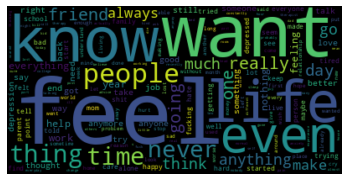

In [5]:
# Cleans text to be used in word cloud
def wordcloud_clean(row):
    row = contractions.fix(row)

    tokens = word_tokenize(row)
    tokens = [w.lower() for w in tokens]
    stop_words = set(stopwords.words('english'))
    words = [w for w in tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]

    mystring = ' '.join(map(str, words))

    return mystring

posts_df["wordcloud_txt"] = posts_df["cleaned_text"].apply(lambda x: wordcloud_clean(x))

text = ""

for index, row in posts_df.iterrows():
    text += row['wordcloud_txt']

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
posts_df.to_csv("RedditDataCleaned.csv")

Next I need to convert the time I got from the reddit API which is seconds since unix epoch into US central time so that I can split up reddit posts based on the time of day.

In [7]:
def convert_time(row):
        time = datetime.datetime.fromtimestamp(row)
        time = time.astimezone(pytz.timezone('US/Central')).strftime('%Y-%m-%d %H:%M:%S %Z%z')
        return time

posts_df["time"] = posts_df["created_utc"].apply(lambda x: convert_time(x))

## Sentiment Analysis